<a href="https://colab.research.google.com/github/captaincapsaicin/slc22a5/blob/main/slc22a5_single_mutants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install biopython

# Download wildtype and potts models

The potts model weights are saved as npz files, which hold bias and coupling terms for trained models corresponding to alignments. See the manuscript for more details on the alignments.

In [2]:
# wildtype
!wget -q http://s3.amazonaws.com/songlabdata/slc22a5/O76082.fasta

# potts state dicts
!wget -q http://s3.amazonaws.com/songlabdata/slc22a5/potts/deepsequence.npz
!wget -q http://s3.amazonaws.com/songlabdata/slc22a5/potts/eve.npz
!wget -q http://s3.amazonaws.com/songlabdata/slc22a5/potts/hhblits.npz
!wget -q http://s3.amazonaws.com/songlabdata/slc22a5/potts/mammals_30.npz
!wget -q http://s3.amazonaws.com/songlabdata/slc22a5/potts/vertebrates_100.npz

# Set up utility functions

In [3]:
import os

import numpy as np
import pandas as pd

In [4]:
# https://github.com/nickbhat/mogwai/blob/main/mogwai/vocab.py


from typing import Sequence, List

class _FastaVocab:

    def __init__(self):
        self.ALPHABET = "ARNDCQEGHILKMFPSTWYV-"
        self.A2N = {a: n for n, a in enumerate(self.ALPHABET)}
        self.A2N["X"] = 20

        self.IUPAC_CODES = {
            "Ala": "A",
            "Arg": "R",
            "Asn": "N",
            "Asp": "D",
            "Cys": "C",
            "Gln": "Q",
            "Glu": "E",
            "Gly": "G",
            "His": "H",
            "Ile": "I",
            "Leu": "L",
            "Lys": "K",
            "Met": "M",
            "Phe": "F",
            "Pro": "P",
            "Ser": "S",
            "Thr": "T",
            "Trp": "W",
            "Val": "V",
            "Tyr": "Y",
            "Asx": "B",
            "Sec": "U",
            "Xaa": "X",
            "Glx": "Z",
        }

        self.THREE_LETTER = {aa: name for name, aa in self.IUPAC_CODES.items()}

    def convert_indices_to_tokens(self, indices: Sequence[int]) -> List[str]:
        return [self.ALPHABET[i] for i in indices]

    def convert_tokens_to_indices(self, tokens: Sequence[str], skip_unknown: bool = False) -> List[int]:
        if skip_unknown:
            return [self.A2N[token] for token in tokens if token in self.A2N]
        else:
            return [self.A2N.get(token, 20) for token in tokens]

    def tokenize(self, sequence: str) -> List[int]:
        return self.convert_tokens_to_indices(list(sequence))

    def __len__(self) -> int:
        return 20

    @property
    def pad_idx(self) -> int:
        return 20


FastaVocab = _FastaVocab()

In [5]:
# https://github.com/google-research/slip/blob/main/utils.py#L27
def onehot(labels, num_classes):
  """Convert integer encoded sequences to onehot format.
  Args:
    labels: 2D ndarray of integer-encoded sequences, num_seqs x seq_len
    num_classes: Number of classes
  Returns:
    3D onehot encoded array, num_seqs x seq_len x num_classes
  """
  if len(np.shape(labels)) == 3:  # if already one-hot, return labels
    return labels
  elif isinstance(labels, list):
    labels = np.asarray(labels)  # ndarray view
  x = (labels[Ellipsis, None] == np.arange(num_classes)[None])
  return x.astype(np.float32)

In [6]:
# https://github.com/google-research/slip/blob/main/sampling.py#L76

def get_all_single_mutants(sequence,
                           vocab_size):
  """Returns all single mutants of given `sequence`.
  For a given sequence, at each position there are `vocab_size` - 1 possible
  mutations.
  Args:
    sequence: A 1d vector of ints.
    vocab_size: The vocabulary size.
  Returns:
    A [(V-1)*L, L] numpy array of integer encoded sequences, where L is the
    length of the sequence and V is the vocab size.
  """
  sequence = np.array(sequence)
  seq_length = len(sequence)

  all_singles = []
  for pos in range(seq_length):
    num_singles = vocab_size - 1
    singles_at_pos = np.tile(sequence, (num_singles, 1))
    delta = np.arange(1, vocab_size, 1)
    singles_at_pos[:, pos] = (singles_at_pos[:, pos] + delta) % vocab_size
    all_singles.append(singles_at_pos)
  return np.vstack(all_singles)




# https://github.com/google-research/slip/blob/main/potts_model.py#L315
def load_from_mogwai_statedict(path):
    state_dict = np.load(path)
    couplings = -1 * state_dict['weight']
    bias = -1 * state_dict['bias']
    
    # Reshape the couplings from Mogwai. L, A, L, A -> L, L, A, A
    couplings = np.moveaxis(couplings, [0, 1, 2, 3], [0, 2, 1, 3])
    return bias, couplings

def potts_energy(sequences, couplings, field, vocab_size=20):
  """Compute the Potts model energy."""
  if len(np.asarray(sequences).shape) == 1:  # single sequence
    sequences = np.reshape(sequences, (1, -1))
  # one-hot representation
  onehot_seq = onehot(sequences, num_classes=vocab_size)
  # (i, j, k, l, b) = (residue1, residue2, amino1, amino2, batch)
  linear_term = np.einsum(
      'ij,bij->b', field, onehot_seq, optimize='optimal') 
  quadratic_term = 0.5 * np.einsum(
      'ijkl,bik,bjl->b',
      couplings,
      onehot_seq,
      onehot_seq,
      optimize='optimal')

  return linear_term + quadratic_term



In [7]:
from Bio import SeqIO

def get_wildtype():
    """Read the wildtype sequence

    Returns
        Bio.Seq
    """
    wildtype_fasta = "O76082.fasta"
    with open(wildtype_fasta, "rU") as f:
        for record in SeqIO.parse(f, "fasta"):
            octn2_wildtype = record.seq
    return octn2_wildtype


def get_mutation_strings(sequences, reference_sequence):
    mutation_strings = []
    for sequence in sequences:
        mutation_string = ''
        differences = sequence != reference_sequence
        for i in range(len(differences)):
            if differences[i]:
                ref_aa = FastaVocab.ALPHABET[reference_sequence[i]]
                aa = FastaVocab.ALPHABET[sequence[i]]
                index = i
                mutation_string += '{}{}{} '.format(ref_aa, index, aa)
        mutation_strings.append(mutation_string.strip())
    return mutation_strings

def get_single_mutant_energies_for_alignment(path, reference_seq):
    bias, couplings = load_from_mogwai_statedict(path)

    single_mutants = get_all_single_mutants(reference_seq, vocab_size=20)
    sequences = np.vstack([reference_seq, single_mutants])
    energies = potts_energy(sequences, couplings, bias, vocab_size=20) 
    
    reference_energy = potts_energy(reference_seq, couplings, bias, vocab_size=20)
    delta_energies = energies - reference_energy  # normalize to 0
    mutation_strings = get_mutation_strings(sequences, reference_seq)
    return {'delta_energy': delta_energies, 'energy': energies, 'mutation_string': mutation_strings}

# Compute single mutant energies and save to CSV

In [8]:

wildtype_seq = get_wildtype()
tokenized_wildtype = FastaVocab.tokenize(wildtype_seq)

name_to_filename = {'hhblits': 'hhblits.npz',
                    'deepsequence': 'deepsequence.npz',
                    'eve': 'eve.npz',
                    '100_vertebrates': 'vertebrates_100.npz',
                    '30_mammals': 'mammals_30.npz'
}

for name, filename in name_to_filename.items():
    print(name)
    path = filename
    single_mutant_dict = get_single_mutant_energies_for_alignment(path, tokenized_wildtype)
    df = pd.DataFrame.from_dict(single_mutant_dict)
    outfile = '{}_single_mutant_energies.csv'.format(name)
    df.to_csv(outfile)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: 'U' mode is deprecated
  # Remove the CWD from sys.path while we load stuff.


hhblits
deepsequence
eve
100_vertebrates
30_mammals


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_position_from_mutation_string(mutation_string):
    if len(mutation_string) == 0: # wildtype
        return None
    index = mutation_string[1:-1]
    return int(index)

alignment = 'hhblits'
df = pd.read_csv('{}_single_mutant_energies.csv'.format(alignment))
df = df.dropna()  # get rid of wildtype rows
df['position'] = df.mutation_string.apply(get_position_from_mutation_string)

Do a quick visualization of which positions are worst

Text(0.5, 1.0, 'Average delta energy per position for hhblits')

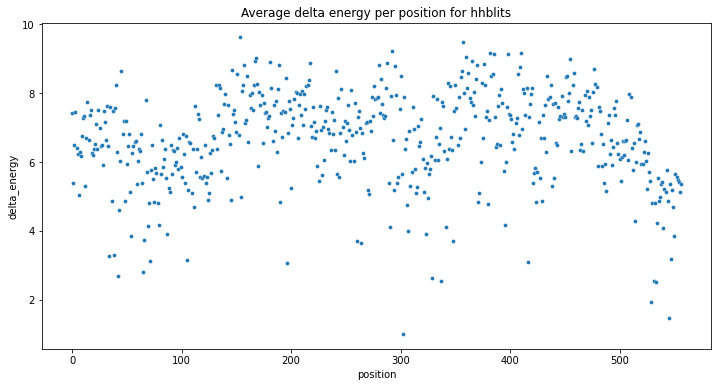

In [10]:
plt.figure(figsize=(12, 6))
grouped_df = df.groupby('position').agg({'delta_energy': 'mean'}).reset_index()
sns.scatterplot(data=grouped_df, x='position', y='delta_energy', s=16)
plt.title(f'Average delta energy per position for {alignment}')

In [13]:
grouped_df.sort_values(by='delta_energy', ascending=False).head(10)

,position,delta_energy
153,153,9.622983
357,357,9.501696
292,292,9.243228
410,410,9.178557
382,382,9.158614
385,385,9.142026
398,398,9.137246
360,360,9.059814
168,168,9.032586
455,455,9.007543
